<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 4.

# 0. Load libraries

In [156]:
from matplotlib import  pyplot as plt
import numpy as np
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf
import plotly.graph_objects as go

%matplotlib inline
from PIL import Image
from matplotlib import animation
from matplotlib import cm
from IPython.display import HTML
from sklearn.datasets import make_blobs

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

In [157]:
import os
import tarfile

In [158]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

In [159]:
from utils.routines import *

# 1. Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [160]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [2.18506063] ;  b = -6.78586433061239


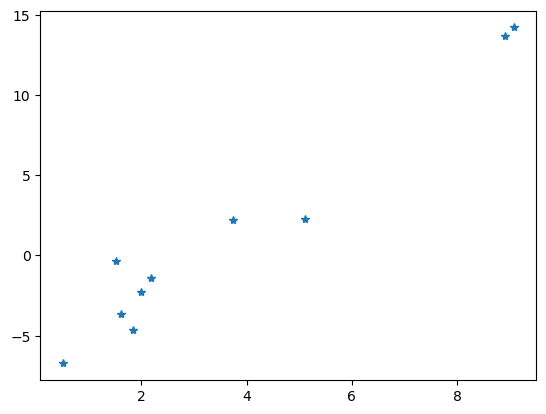

In [161]:
x, y = get_linear(n_d=1, sigma=1)
plt.plot(x[:, 0], y, '*')
plt.show()

true slopes: w = [3.22506811 9.95077182] ;  b = -4.485609697504485


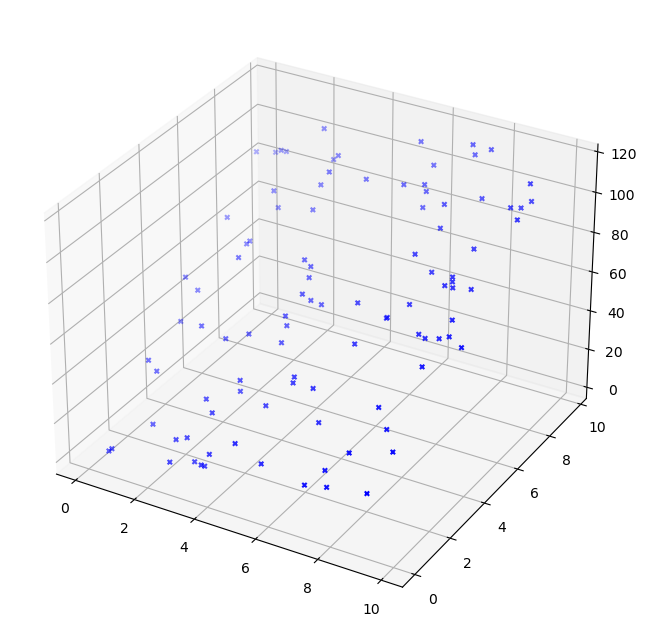

In [162]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=10)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [163]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [164]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


In [165]:
df.describe()

,Order,PID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2929.000000,2.929000e+03,2929.000000,2439.000000,2929.00000,2929.000000,2929.000000,2929.000000,2929.000000,2906.000000,...,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000
mean,1465.461591,7.143956e+08,57.379652,69.223042,10148.06282,6.095254,5.563332,1971.344486,1984.258791,101.931865,...,93.749744,47.549676,23.019461,2.593377,16.007511,2.244111,50.652441,6.216456,2007.790372,180800.599522
std,846.104363,1.887262e+08,42.643257,23.370001,7881.35958,1.411122,1.111678,30.243747,20.859616,179.133457,...,126.383085,67.489204,64.148601,25.145578,56.096167,35.603235,566.440219,2.714863,1.316832,79899.955086
min,1.000000,5.263011e+08,20.000000,21.000000,1300.00000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.000000,5.284770e+08,20.000000,58.000000,7440.00000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.000000,5.354532e+08,50.000000,68.000000,9434.00000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2198.000000,9.071811e+08,70.000000,80.000000,11556.00000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.000000,1.007100e+09,190.000000,313.000000,215245.00000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


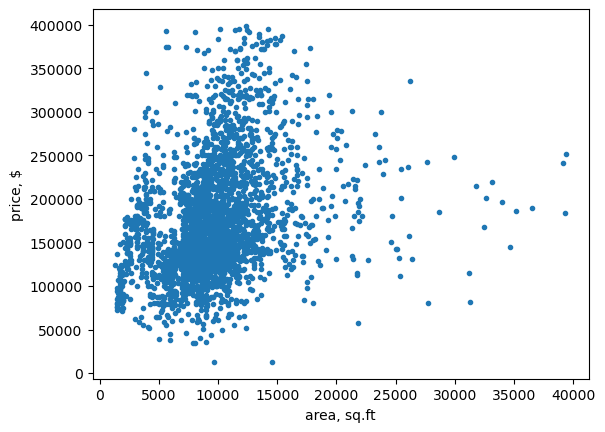

In [166]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

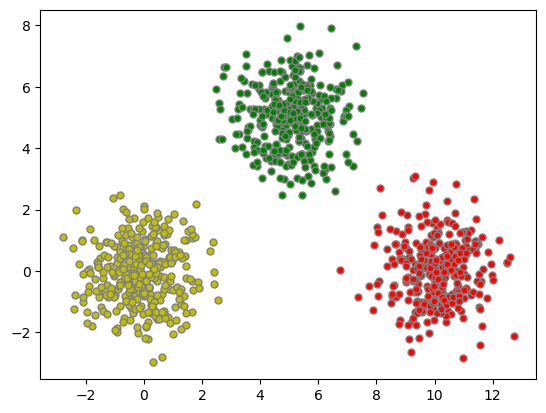

In [167]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

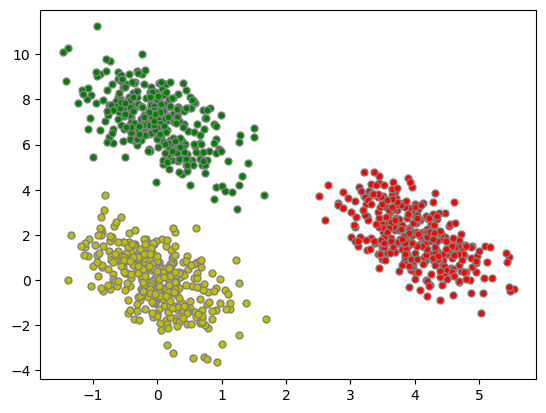

In [168]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])

transformation = [[0.4, 0.2], [-0.4, 1.2]]  # affine transformation matrix
x = np.dot(x, transformation)               # applied to point coordinated to make blobs less separable

colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()



## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [169]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

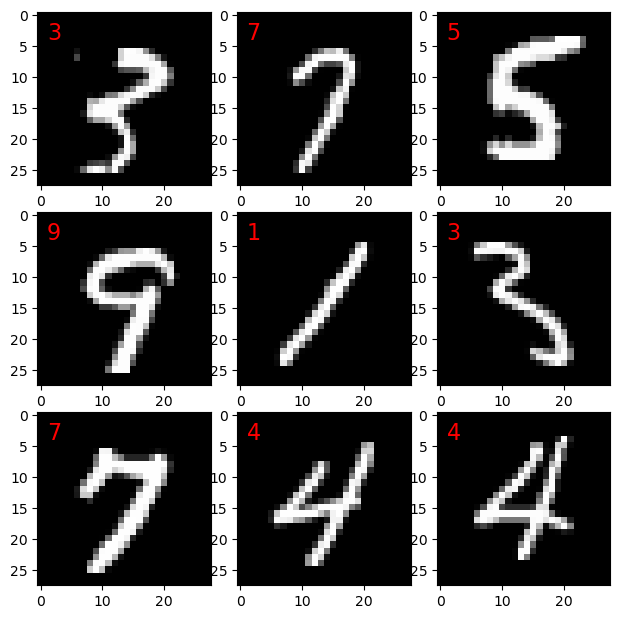

In [170]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [171]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

TypeError: tight_layout() takes 0 positional arguments but 3 were given

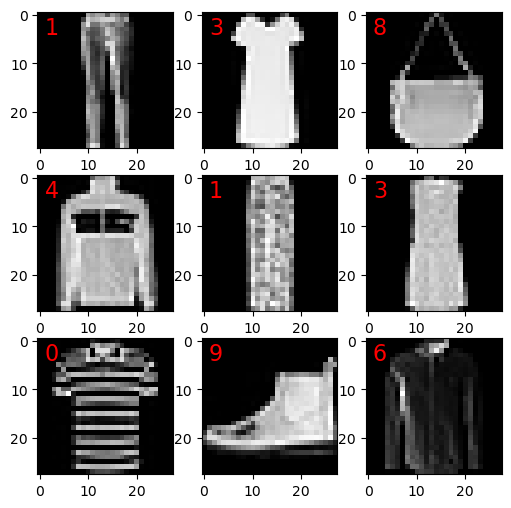

In [172]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

In [ ]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 6. Weather dataset

This is a weather time series [dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the Max Planck Institute for Biogeochemistry
It contains weather reacord for 8 years of observation.

In [ ]:
def get_weather_df():
  # inspired by https://www.tensorflow.org/tutorials/structured_data/time_series

  # download and extract dataset
  zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
  csv_path, _ = os.path.splitext(zip_path)

  # load into pandas df
  df = pd.read_csv(csv_path)

  # dataset contains records every 10 min, we use hourly records only, thus
  # slice [start:stop:step], starting from index 5 take every 6th record
  df = df[5::6]

  # replace errors in wind velocity to 0
  wv = df['wv (m/s)']
  bad_wv = wv == -9999.0
  wv[bad_wv] = 0.0

  max_wv = df['max. wv (m/s)']
  bad_max_wv = max_wv == -9999.0
  max_wv[bad_max_wv] = 0.0

  # obtain timestamps from text time format
  date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  # genarate cyclic features for year and day
  day = 24*60*60
  year = (365.2425) * day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  return df

In [ ]:
weather_df = get_weather_df()

In [ ]:
weather_df.head()

In [ ]:
weather_df.describe().T

In [ ]:
plt.plot(weather_df['Year cos'])
plt.plot(weather_df['Year sin'])

In [ ]:
plt.plot(weather_df['Day cos'][:7*24])
plt.plot(weather_df['Day sin'][:7*24])

In [ ]:
def gen_future_T_dataset(X_len=24, Y_offset=48,
                         X_features=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
                         Y_features='T (degC)',
                         standardize=True,
                         oversample=10
                         ):
  """
  Generates pairs of input-label, using sequence of `X_len` samples as input
  and value at offset `Y_offset` from start of this sequence as label.
  Sample sequnces arte taken at random positions throughout the dataset.
  Number of samples is obtained assuming non-overlaping wondows.
  Oversampling factor allows to increase this value.

  Args:
    X_len (int): length of sample sequence
    Y_offset (int): offset to the target value from the sequence start
    X_features (list or str): features to be used as input
    Y_features (list or str): features to be used as labels
    standardize (Bool): flag whether to standardize the columns
    oversample (int): increases number of samples by this factor wrt baseline
                      n = len(df) // (Y_offset+1)
  """
  weather_df = get_weather_df()

  if standardize:
    mean = weather_df.mean()
    std = weather_df.std()
    weather_df = (weather_df - mean) / std

  df_X = weather_df[X_features]
  df_Y = weather_df[Y_features]

  n_records = len(df_X)
  sample_len = Y_offset+1
  n_samples = int((n_records-sample_len)//sample_len*oversample)
  offsets = np.random.randint(0, n_records-sample_len, size=n_samples)
  offsets.sort()

  X = []
  Y = []
  for o in offsets:
    X.append(np.array(df_X[o:o+X_len]))
    Y.append(np.array(df_Y[o+Y_offset:o+Y_offset+1]))

  X = np.stack(X)
  Y = np.concatenate(Y)

  return X, Y

In [ ]:
x, y = gen_future_T_dataset()

In [ ]:
x.shape, y.shape

In [ ]:
for f,fn in enumerate(['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']):
  plt.figure(figsize=(5*(1+(f==1)), 4))
  for s in range(10):
    plt.plot(x[s, :, f])
    if f==1:
      plt.scatter(48, y[s], color=plt.gca().lines[-1].get_color())
  plt.title(fn)
  plt.show()

# 2. Neural Networks Introduction

## 1. Perceptron

(Artificial) Neural network consists of layers of neurons. Artificial neuron, or perceptron, is in fact inspired by a biological neuron.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/Perceptron.png" alt="drawing" width="30%"/>

Such neuron first calculates the linear transformation of the input vector $\bar x$:
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.



**This is effectively linear regression.** ( if you have only linear input. However you can also input non-linear input here). You can combine those parallely to make a multidimensional prediction in parallel, e.g.:

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/2Perceptrons.png" alt="drawing" width="30%"/>

you could e.g. predict the number of bathrooms on first and second floor in parallel.

Strongly recommended. Input units and even value ranges should be unified / standardized. You can then retransform (multiply) your output to get the value ranges / units you want

## 2. Nonlinearity

Combining multiple such objects performing linear transformation sequentially would not bring any additional benefit, as the combined output would still be a linear combination of the inputs.

What gives actual power to neurons, is that they additionally perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$

The most commonly used non-linear transformations are:

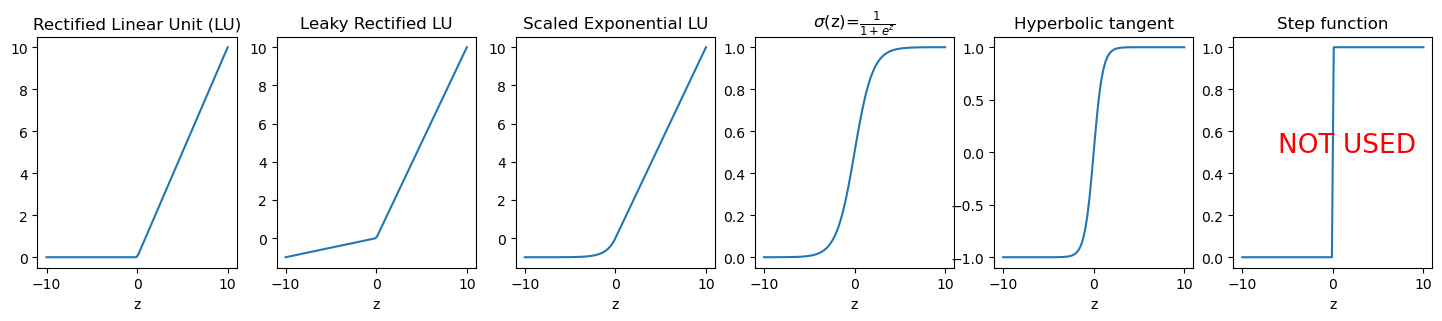

In [174]:
def ReLU(z):
  return np.clip(z, a_min=0, a_max=np.max(z))
def SELU(z, a=1):
  p = np.clip(z, a_min=0, a_max=np.max(z))
  n = np.clip(z, a_min=np.min(z), a_max=0)
  return p + (np.exp(n)-1) * a
def LReLU(z, a=0.1):
  return np.clip(z, a_min=0, a_max=np.max(z)) + np.clip(z, a_min=np.min(z), a_max=0) * a
def sigmoid(z):
  return 1/(1 + np.exp(-z))
def step(z):
  return np.heaviside(z, 0)
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
z = np.linspace(-10, 10, 100)
ax[0].plot(z, ReLU(z))
ax[0].set_title('Rectified Linear Unit (LU)')
ax[1].plot(z, LReLU(z))
ax[1].set_title('Leaky Rectified LU')
ax[2].plot(z, SELU(z))
ax[2].set_title('Scaled Exponential LU')
ax[3].plot(z, sigmoid(z))
ax[3].set_title(r'$\sigma$(z)=$\frac{1}{1+e^z}$')
ax[4].plot(z, np.tanh(z))
ax[4].set_title('Hyperbolic tangent');
ax[5].plot(z, step(z))
ax[5].text(-6, 0.5, 'NOT USED', size=19, c='r')
ax[5].set_title('Step function');
for axi in ax:
  axi.set_xlabel('z')
plt.show()

And the reason we don't use a simple step function, is that it's everywhere either not differentiable or its derivative is zero.

The last nonlinearity to mention here is *softmax*:
$$y_i = SoftMax(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

While each $z_i$ can have any value, the corresponding $y_i\in[0,1]$, and $\sum_i y_i=1$, just like probabilities!

While these $y_i$ are only pseudo-probabilities, this nonlinearity allows one to model probabilities, e.g. of a data-point belonging to a certain class.

#rectified linear unit: used a lot, only one non-derivative spot (at 0). It clips everything below 0.





## 3. Fully connected net

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$ (upper index denotes layer): $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vector.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/MLP.png" alt="drawing" width="50%"/>


#RIM: Why use different layers? downstream layers combine upstream input into some more useful features for your analysis. e.g. combine several meteorological inputs to classify into a new seasonal variable

activiation function at the end of the network (here layer 3) classifies the output to one of two categories, if you desire this.
for a continuous output, most likely no activation function will be applied

## 4. Loss function

The last part of the puzzle is the measure of network performance, which is used to optimize the network's parameters $W^l_j$ and $b^l_j$.
Denoting the network's output for an input $x_i$ as $\hat y_i=\hat y_i(x_i)$ and given the label $y_i$:

1. In case of regression loss shows "distance" from target values:
* L2 (MSE): $L = \sum_i (y_i-\hat y_i)^2$
* L1 (MAE): $L = \sum_i |y_i-\hat y_i|$

1. In case of classification we can use cross-entropy, which shows "distance" from target distribution:
$$L = - \sum_i \sum_c y_{i,c} \log(\hat y_{i,c})$$
Here $\hat y_{i,c}$ - pseudo-probability of $x_i$ belonging to class $c$ and $y_{i,c}$ uses 1-hot encoding:

$$y_{i,c}=
\begin{cases}
    1,& \text{if } x_i \text{ belongs to class } c\\
    0,              & \text{otherwise}
\end{cases}$$


## 5. Training

Training of neural networks is performed iteratively. The weights  $W^l_j$ and $b^l_j$ are updated on each iteration of training according to the value of the derivative of the loss function with respect to corresponding parameter:
$$W^l_j \rightarrow W^l_j - \lambda \frac{\partial L}{\partial W^l_j }$$
$$b^l_j \rightarrow b^l_j - \lambda \frac{\partial L}{\partial b^l_j },$$

This is Gradient Descent optimization with learning rate $\lambda$. The partial derivatives are calculated by the chain law, and this approach is known as [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

In practice often for each iteration the loss $L$ is evaluated not on all samples, but on a sub-sample, so-called *minibatch* (sometimes - just batch). In most cases the sample order and selection for each minibatch is performed at random rendering this approach to be stochastic (thus it's called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)). One iteration through all training data in minibatches is called *epoch*.

# 3. Regression with neural network

## 2. 1D input

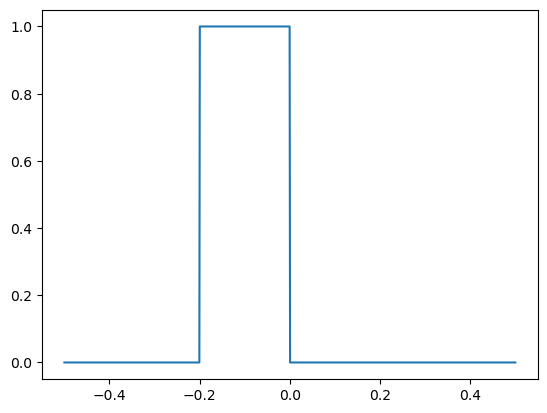

In [175]:
x = np.linspace(0, 10, num=1000)
y = ((x>3)*(x<5)).astype(np.float32)

#y = x**3/500 + np.sin(x) #+ np.sin((10-x)**2)

x /= 10
x -= 0.5
plt.plot(x, y);

RIM: below: hyperparameters: 1 dense layer with 100 neurons, with activation function "relu"
next layer: 1 dense layer with 1 neuron

trainable parameters for each neuron: weight and bias (see above)
first layer: 1 input, 100 weights, 1 bias => 200 parameterx (??)
second layer: 100 inputs, 1 bias = 101 parameters


In [176]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation=None),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 1)                 0         
                                                                 
 dense_18 (Dense)            (None, 100)               200       
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [177]:
class saving_pred(tf.keras.callbacks.Callback):
  def __init__(self):
    self.y_preds = []

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
        y_p = model.predict(x).flatten()
        #print('\n', epoch, y_p.shape, '\n\n')
        self.y_preds.append(y_p)

In [178]:
saving_callback = saving_pred()
hist = model.fit(x, y,
                 epochs=300, batch_size=100, callbacks=[saving_callback])

Epoch 1/300
10/10 [==============================] - 0s 9ms/step - loss: 0.2227 - mse: 0.1815
Epoch 2/300
10/10 [==============================] - 0s 911us/step - loss: 0.2029 - mse: 0.1755
Epoch 3/300
10/10 [==============================] - 0s 1ms/step - loss: 0.2007 - mse: 0.1695
Epoch 4/300
10/10 [==============================] - 0s 922us/step - loss: 0.1989 - mse: 0.1693
Epoch 5/300
10/10 [==============================] - 0s 785us/step - loss: 0.1973 - mse: 0.1698
Epoch 6/300
10/10 [==============================] - 0s 886us/step - loss: 0.1976 - mse: 0.1696
Epoch 7/300
10/10 [==============================] - 0s 818us/step - loss: 0.1966 - mse: 0.1666
Epoch 8/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1951 - mse: 0.1630
Epoch 9/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1955 - mse: 0.1626
Epoch 10/300
10/10 [==============================] - 0s 807us/step - loss: 0.1940 - mse: 0.1604
Epoch 11/300
10/10 [===========================

10/10 [==============================] - 0s 678us/step - loss: 0.1334 - mse: 0.0465
Epoch 157/300
10/10 [==============================] - 0s 711us/step - loss: 0.1296 - mse: 0.0423
Epoch 158/300
10/10 [==============================] - 0s 736us/step - loss: 0.1222 - mse: 0.0395
Epoch 159/300
10/10 [==============================] - 0s 697us/step - loss: 0.1214 - mse: 0.0392
Epoch 160/300
10/10 [==============================] - 0s 678us/step - loss: 0.1177 - mse: 0.0385
Epoch 161/300
10/10 [==============================] - 0s 7ms/step - loss: 0.1182 - mse: 0.0404
Epoch 162/300
10/10 [==============================] - 0s 701us/step - loss: 0.1149 - mse: 0.0370
Epoch 163/300
10/10 [==============================] - 0s 716us/step - loss: 0.1173 - mse: 0.0381
Epoch 164/300
10/10 [==============================] - 0s 765us/step - loss: 0.1143 - mse: 0.0374
Epoch 165/300
10/10 [==============================] - 0s 714us/step - loss: 0.1135 - mse: 0.0374
Epoch 166/300
10/10 [===============

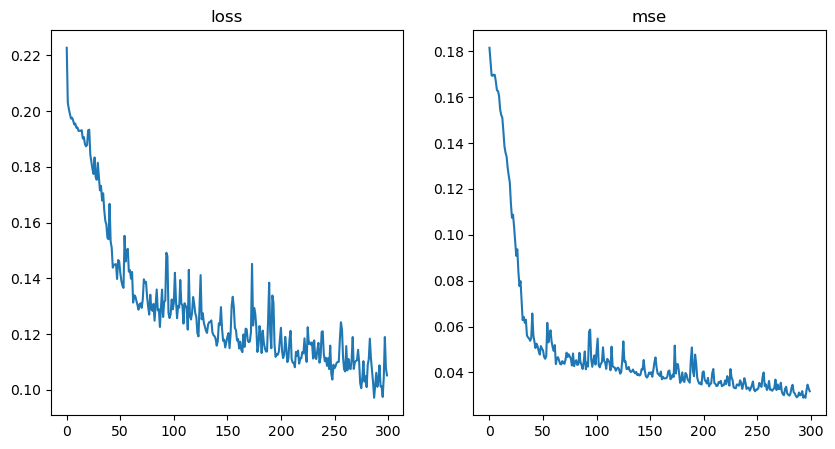

In [179]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

32/32 [==============================] - 0s 675us/step


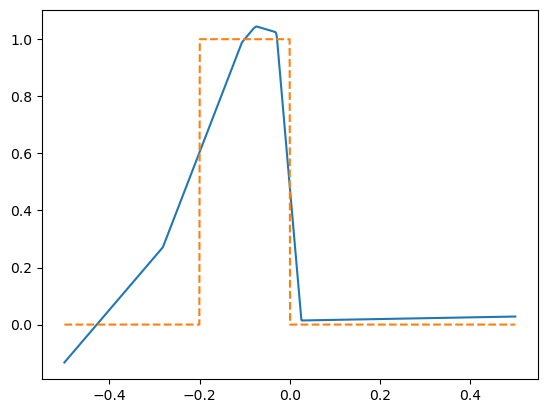

In [180]:
y_p = model.predict(x)
im = plt.plot(x, y_p)
im = plt.plot(x, y, '--')
plt.show()

RIM: above: the input was x-coordinates, and for each x-coord. it predicts a y-coord. prediction is not perfect here

In [181]:

%%capture
y_preds = saving_callback.y_preds

fig = plt.figure()
line = plt.plot(x, y_preds[0])
line2 = plt.plot(x, y)

def animate(i):
    y_p = y_preds[i]
    line[0].set_data((x, y_p))
    return line

ani = animation.FuncAnimation(fig, animate, frames=len(y_preds))

In [182]:
ani

## 2. 2D input

Here we will build a neural network to perform regression in 2D: we will fit $(x,y)$ pixel coordinates of an image to the pixel brightness at that location.

RIM: in graysscale, the brightness values for eeach x/y is one value, between 0 and 255

/var/folders/3f/fq1cp83n5sq16c_d53znhsfh0000gn/T/ipykernel_82652/1793758380.py:2: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



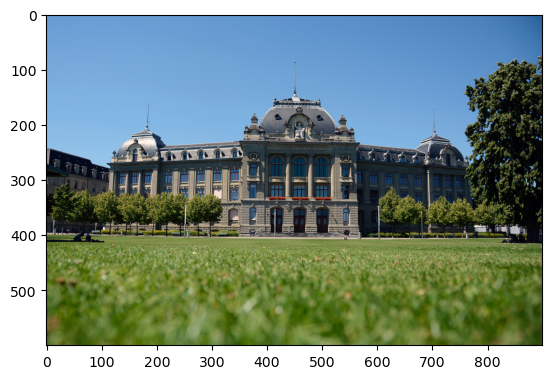

In [183]:
url = 'https://github.com/neworldemancer/DSF5/raw/master/figures/unibe.jpg'
image_big = imread(url)
image_big = image_big[...,0:3]/255
plt.imshow(image_big)
plt.show()

In [184]:
def subsample(im, factor):
  h, w = im.shape[:2]
  h = int(h/factor)
  w = int(w/factor)

  img = Image.fromarray((im*255).astype('uint8'))
  newimg = img.resize((w, h), Image.ANTIALIAS)
  return np.asarray(newimg)/255

/var/folders/3f/fq1cp83n5sq16c_d53znhsfh0000gn/T/ipykernel_82652/2121674518.py:7: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.



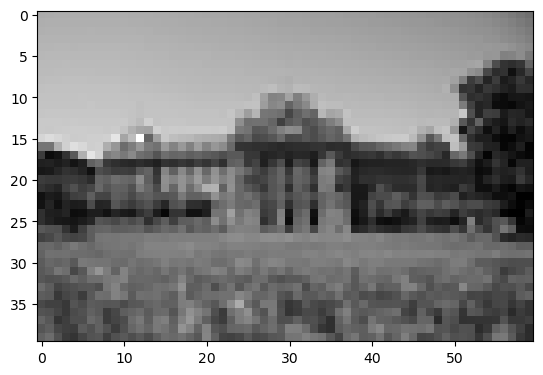

In [185]:
image = subsample(image_big, 15)
image = image.mean(axis=2, keepdims=True)
plt.imshow(image[...,0], cmap='gray')
plt.show()

In [186]:
h, w, c = image.shape

In [187]:
X0 = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X0, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((2400, 2), (2400, 1))

In [188]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 2)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [189]:
hist = model.fit(X, Y, epochs=500, batch_size=2048)

Epoch 1/500
2/2 [==============================] - 0s 3ms/step - loss: 0.3316 - mse: 0.1569
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3311 - mse: 0.1565
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3306 - mse: 0.1560
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3301 - mse: 0.1555
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3296 - mse: 0.1551
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3291 - mse: 0.1546
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3286 - mse: 0.1542
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3281 - mse: 0.1537
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3276 - mse: 0.1533
Epoch 10/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3271 - mse: 0.1528
Epoch 11/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3265 

2/2 [==============================] - 0s 2ms/step - loss: 0.2533 - mse: 0.0852
Epoch 177/500
2/2 [==============================] - 0s 3ms/step - loss: 0.2529 - mse: 0.0849
Epoch 178/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2525 - mse: 0.0846
Epoch 179/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2521 - mse: 0.0843
Epoch 180/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2517 - mse: 0.0839
Epoch 181/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2514 - mse: 0.0836
Epoch 182/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2510 - mse: 0.0833
Epoch 183/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2506 - mse: 0.0830
Epoch 184/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2502 - mse: 0.0826
Epoch 185/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2498 - mse: 0.0823
Epoch 186/500
2/2 [==============================] - 0s 2ms/step - loss: 0

2/2 [==============================] - 0s 2ms/step - loss: 0.1883 - mse: 0.0465
Epoch 351/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1880 - mse: 0.0464
Epoch 352/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1878 - mse: 0.0463
Epoch 353/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1875 - mse: 0.0462
Epoch 354/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1873 - mse: 0.0461
Epoch 355/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1870 - mse: 0.0461
Epoch 356/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1868 - mse: 0.0460
Epoch 357/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1866 - mse: 0.0459
Epoch 358/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1863 - mse: 0.0458
Epoch 359/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1861 - mse: 0.0458
Epoch 360/500
2/2 [==============================] - 0s 2ms/step - loss: 0

75/75 [==============================] - 0s 407us/step


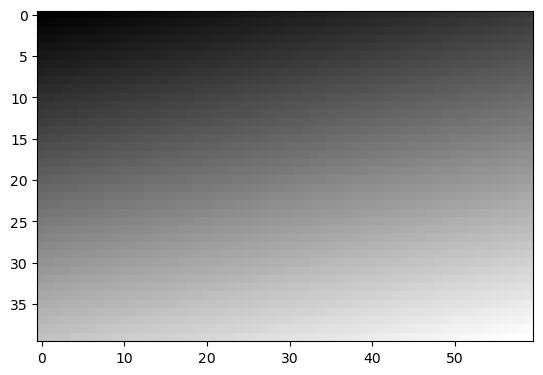

In [190]:
Y_p = model.predict(X)
Y_p = Y_p.reshape((h,w,c))
im = plt.imshow(Y_p[...,0], cmap='gray')
plt.show()

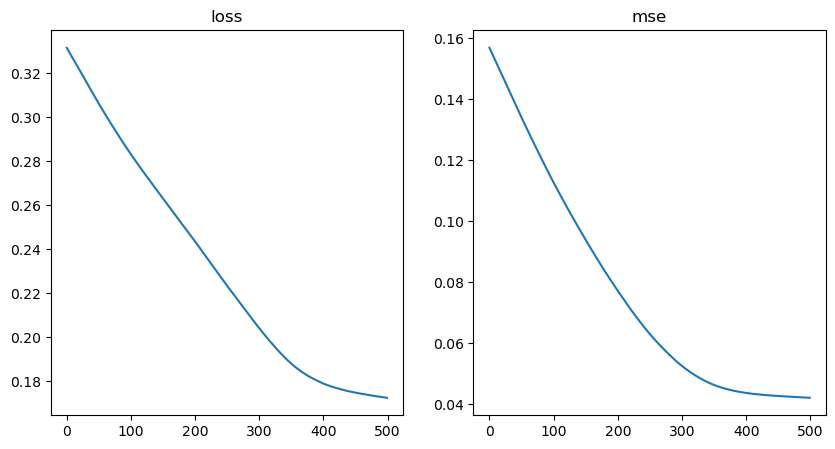

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

What is actually happening here? We fit an image with an $\mathbb{R}^2 \rightarrow \mathbb{R}$ funcion.

In [192]:

x = X[:,0].reshape((h,w))
y = X[:,1].reshape((h,w))
z = Y.reshape((h,w))
zp = Y_p.reshape((h,w))

ds = 2
x = subsample(x, ds)
y =-subsample(y, ds)
z = subsample(z, ds)
zp = subsample(zp, ds)

#surf = ax.plot_surface(x,y,z, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.3)
#surf = ax.plot_surface(x,y,zp, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)
#plt.show()

fig = go.Figure(data=[go.Surface(z=zp, x=x, y=y)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

/var/folders/3f/fq1cp83n5sq16c_d53znhsfh0000gn/T/ipykernel_82652/2121674518.py:7: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.



Let's try the same with an RGB image:

/var/folders/3f/fq1cp83n5sq16c_d53znhsfh0000gn/T/ipykernel_82652/2121674518.py:7: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.



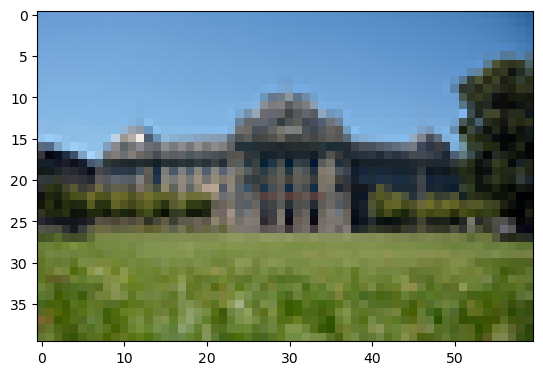

In [193]:
image = subsample(image_big, 15)
plt.imshow(image)
plt.show()

In [194]:
h, w, c = image.shape
X = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((2400, 2), (2400, 3))

In [195]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 3)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


But now we will save images during the course of training, at first after 2, then 4, 8, 16, etc epochs.
(**Remember**: call to `model.fit` does NOT reinitialize trainable variables. Every time it continues from the previous state):

In [196]:
class saving_pred(tf.keras.callbacks.Callback):
  def __init__(self, n_ep_pow):
    self.ims = []
    self.save_epochs = [0]+[2**i for i in range(n_ep_pow)]

  def on_epoch_end(self, epoch, logs=None):
    if epoch in self.save_epochs:
        Y_p = model.predict(X)
        Y_p = Y_p.reshape((h, w, c))
        self.ims.append(Y_p)

75/75 [==============================] - 0s 327us/step


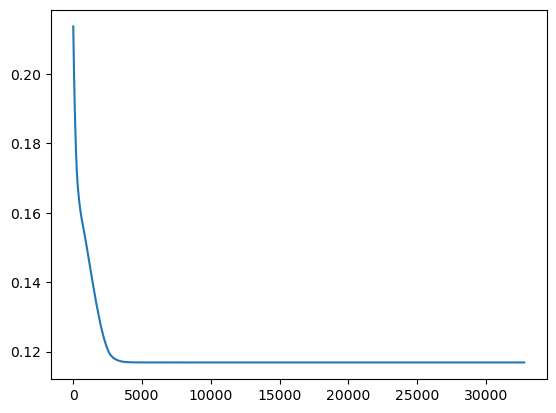

In [197]:
n_ep_pow = 15
n_ep = 2**n_ep_pow+1

ims_callback = saving_pred(n_ep_pow)
hist = model.fit(X, Y, epochs=n_ep, batch_size=1*2048, verbose=0, callbacks=[ims_callback])

plt.plot(hist.epoch, hist.history['loss'])
plt.show()

In [198]:
%%capture

ims = ims_callback.ims
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [199]:
ani

While the colors properly represent the target image, our model still poses very limited capacity, allowing it to effectively represent only 3 boundaries.

Let's upscale our model:

below: in last layer, "c" means color output (3 channels)
we are training the model to predict brightness in 3 separate channels on any x/y coordinate 

In [200]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), # optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 128)               384       
                                                                 
 dense_23 (Dense)            (None, 8)                 1032      
                                                                 
 dense_24 (Dense)            (None, 3)                 27        
                                                                 
Total params: 1443 (5.64 KB)
Trainable params: 1443 (5.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [201]:
X.shape

(2400, 2)

75/75 [==============================] - 0s 341us/step


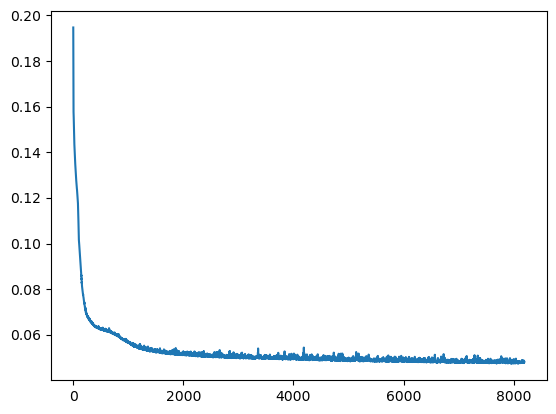

In [202]:
n_ep_pow = 13
n_ep = 2**n_ep_pow+1

ims_callback = saving_pred(n_ep_pow)
hist = model.fit(X, Y, epochs=n_ep, batch_size=1*2048, verbose=0, callbacks=[ims_callback])

plt.plot(hist.epoch, hist.history['loss'])
plt.show()

In [203]:
%%capture

ims = ims_callback.ims
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [204]:
ani

We can also now render the fitted image at any resolution, by evaluating values in between of the original pixels:

67500/67500 [==============================] - 22s 329us/step


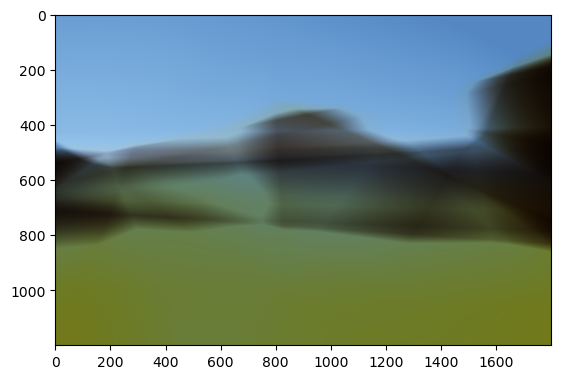

In [205]:
scale = 30
w_rend = w * scale
h_rend = h * scale
X_rend = np.meshgrid(np.linspace(0, 1, w_rend), np.linspace(0, 1, h_rend))
X_rend = np.stack(X_rend, axis=-1).reshape((-1, 2))

Y_rend = model.predict(X_rend)
Y_rend = Y_rend.reshape((h_rend, w_rend, c))

plt.imshow(Y_rend)

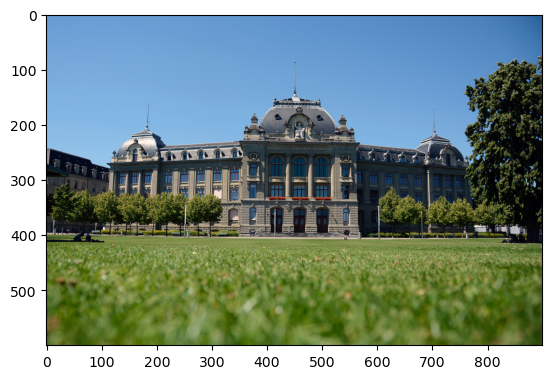

In [206]:
plt.imshow(image_big)

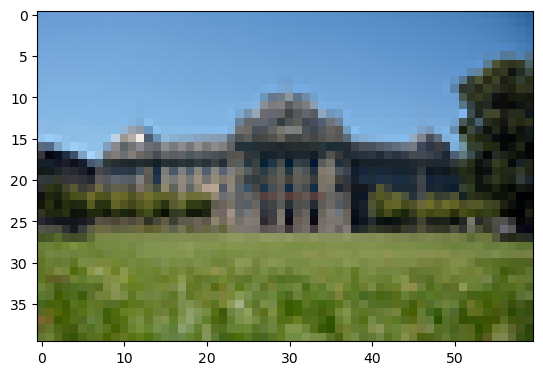

In [207]:
plt.imshow(image)

## EXERCISE 1. Regression on an image with Neural Network.

Load some image, downscale to a similar resolution, and train a deeper model, for example 5 layers, more parameters in widest layers.

In [208]:
# 1. Load your image

# 2. build a deeper model

# 3. inspect the evolution

# 4. Classification of the F-MNIST dataset with neural network

## 0. Load data

We will create a model for classification of the F-MNIST dataset that we go acquainted with in previous sessions. We will normalize the inputs to have values $\in[0,1]$:

In [224]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 1. Building a neural network

In [210]:
print(x_train[0].shape)

(28, 28)


The size of each image sample $-\; 28\times28\text{ pixels}\;-\;$ defines the input size for our neural network. Network's output - probabilities of belonging to each of the 10 classes.

The following creates a 'model'. It is an object containing the neural network model itself - a simple 3-layer fully connected neural network, optimization parameters, as well as the interface for model training.

In [211]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model summary provides information about the model's layers and trainable parameters

In [212]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2. Model training

The `fit` function is the interface for model training.
Here one can specify training and validation datasets, minibatch size, and the number of training epochs.

Here during training we also save the trained models checkpoints after each epoch of training.

In [213]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model.fit(x=x_train, y=y_train,
                 epochs=50, batch_size=128,
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])

Epoch 1/50
469/469 [==============================] - 1s 991us/step - loss: 0.7323 - accuracy: 0.7573 - val_loss: 0.5718 - val_accuracy: 0.8083
Epoch 2/50
469/469 [==============================] - 0s 777us/step - loss: 0.5138 - accuracy: 0.8289 - val_loss: 0.5168 - val_accuracy: 0.8204
Epoch 3/50
469/469 [==============================] - 0s 771us/step - loss: 0.4741 - accuracy: 0.8408 - val_loss: 0.4932 - val_accuracy: 0.8290
Epoch 4/50
469/469 [==============================] - 0s 774us/step - loss: 0.4510 - accuracy: 0.8471 - val_loss: 0.4770 - val_accuracy: 0.8355
Epoch 5/50
469/469 [==============================] - 0s 775us/step - loss: 0.4380 - accuracy: 0.8504 - val_loss: 0.4657 - val_accuracy: 0.8399
Epoch 6/50
469/469 [==============================] - 0s 777us/step - loss: 0.4279 - accuracy: 0.8540 - val_loss: 0.4696 - val_accuracy: 0.8372
Epoch 7/50
469/469 [==============================] - 0s 777us/step - loss: 0.4197 - accuracy: 0.8559 - val_loss: 0.4644 - val_accuracy:

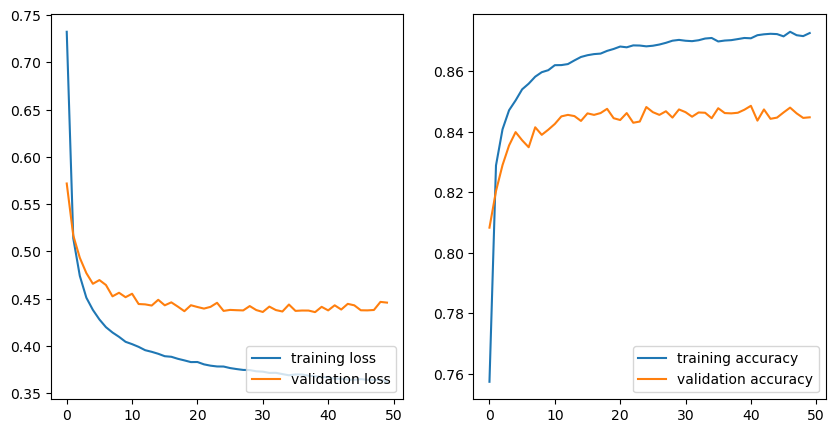

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

Current model performance can be evaluated, e.g. on the test dataset:

---



In [215]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.4457 - accuracy: 0.8448 - 169ms/epoch - 539us/step


[0.4457273781299591, 0.8447999954223633]

We can test trained model on an image:

true lablel:  9 ; predicted:  9 (Ankle boot)


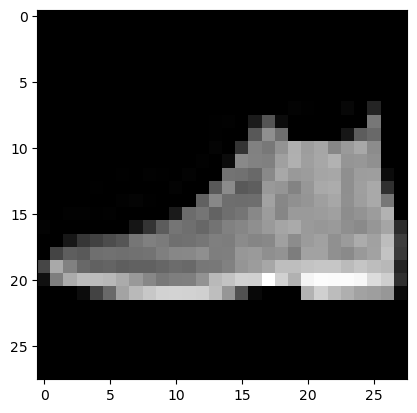

In [216]:
im_id = 0
y_pred = model(x_test)

y_pred_most_probable = np.argmax(y_pred[im_id])
print('true lablel: ', y_test[im_id],
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');

As well as inspect on which samples does the model fail:

true lablel:  7 (Sneaker) ; predicted:  5 (Sandal)


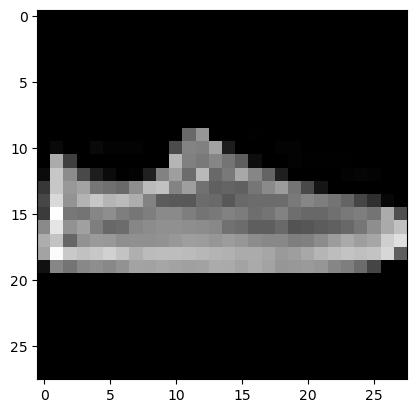

In [225]:
y_pred_most_probable_all = np.argmax(y_pred, axis=1)
wrong_pred_map = y_pred_most_probable_all!=y_test
wrong_pred_idx = np.arange(len(wrong_pred_map))[wrong_pred_map]

im_id = wrong_pred_idx[0]

y_pred_most_probable = y_pred_most_probable_all[im_id]
print('true lablel: ', y_test[im_id],
      f'({class_names[y_test[im_id]]})',
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');
plt.show()

## 3. Loading trained model

In [218]:
model.load_weights('save/mnist_1.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_12.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_18.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.5718 - accuracy: 0.8083 - 172ms/epoch - 549us/step
313/313 - 0s - loss: 0.4442 - accuracy: 0.8451 - 124ms/epoch - 395us/step
313/313 - 0s - loss: 0.4415 - accuracy: 0.8462 - 120ms/epoch - 384us/step


[0.44149643182754517, 0.8461999893188477]

above: we do not want to run the modelfitting all the time (b/c it takes a lot of time!), so we saved the model parameters after every epoch further above and load it here into the model. So we can use the model directly, with the already found "optimal" model parameters

## 4. Inspecting trained variables

We can obtain the trained variables from model layers:

In [219]:
l = model.get_layer(index=1)
w, b = l.weights

w = w.numpy()
b = b.numpy()
print(w.shape, b.shape)
w = w.reshape((28,28,-1)).transpose((2, 0, 1))

(784, 10) (10,)


Let's visualize first 10:

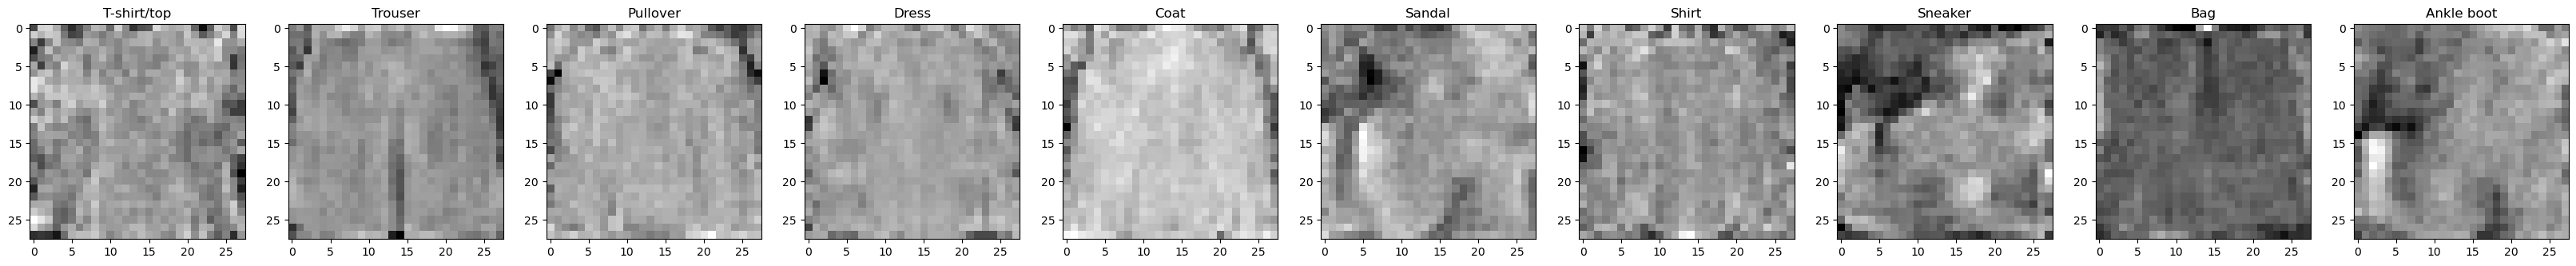

In [220]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(4.1*n,4))
for i, wi in enumerate(w[:n]):
  axs[i].imshow(wi, cmap='gray')
  axs[i].set_title(class_names[i])
plt.show()

This is like a "mask" for the classification into one of the 10 classes. Neuron 1 uses mask 1(t-shirt) and applies the "weights"/brightness of the mask pixel on each input pixel on , the result higher for hits (mask fitting test image) and therefore allows for  classification

## 6. Inspecting gradients

We can also evaluate the gradients of each output with respect to an input:

In [221]:
idx = 112
inp_v = x_train[idx:idx+1]  # use some image to compute gradients with respect to

inp = tf.constant(inp_v)  # create tf constant tensor
with tf.GradientTape() as tape:  # gradient tape for gradint evaluation
  tape.watch(inp)  # take inp as variable
  preds = model(inp) # evaluate model output

grads = tape.jacobian(preds, inp)  # evaluate d preds[i] / d inp[j]
print(grads.shape, '<- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])')
grads = grads.numpy()[0,:,0]

(1, 10, 1, 28, 28) <- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])


prediction: 6


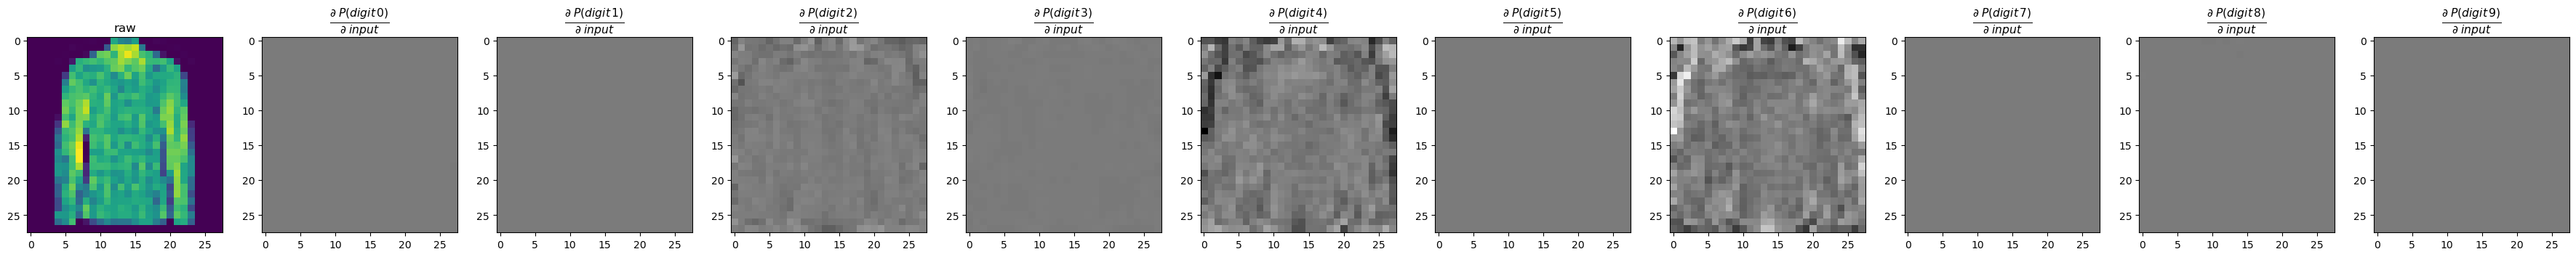

In [222]:
print('prediction:', np.argmax(preds[0]))
fig, axs = plt.subplots(1, 11, figsize=(4.1*11,4))
axs[0].imshow(inp_v[0])
axs[0].set_title('raw')
vmin,vmax = grads.min(), grads.max()
for i, g in enumerate(grads):
  axs[i+1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
  axs[i+1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size':16})
plt.show()

## EXERCISE 2: Train deeper network for F-MNIST classification

Make a deeper model, with wider layers. Remember to use the `'softmax'` activation in the last layer, as required for the classification task to encode pseudoprobabilities. In the other layers you could use `'relu'`.

Try to achieve 90% accuracy.
Does your model overfit?

In [223]:
# 1. create model
# 2. train the model
# 3. plot the loss and accuracy evolution during training
# 4. evaluate model in best point (before overfitting)

# 5. Extras and Q&A

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/cheatsheet.png" width="100%"/>

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/clusters.png" width="100%"/>